In [1]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

read the csv after finding horizontal threshold, vertical thresholds. make it such that it follows the given format

final csv is the csv that has columns Id, Top-Left, Bottom-Right, Top, Left, Bottom, Right, Top_box, Bottom_box, Left_box, Right_box

Id - refers to box ID -> int

Top-Left,Bottom-Right - refers to the xy coordinates of topleft and bottomright coordinate of a bounding box

Top/Left/Bottom/Right - refers to the coordinates of edge centers

Top_box/Bottom_box/Left_box/Right_box - refers to the nearest box from current box such that the words across paragraphs or columns should not get connected -> List:[dist, nearest box ID]


Given below are two functions to visualize the document image and the connections established.

visualize_bboxes() can be used to visualize a document image with the bounding boxes around words. Bounding box information is given in the CSVs provided

make_connections() can be used to verify and visualize the connections established between words such that it satisfies the given criteria of grouping words in a logical paragraph. This function has to be used after getting the final csv in the specified format

In [2]:
def visualize_bboxes(img, df):
  img_2 = img.copy()
  for index, rows in df.iterrows():
    top_left = (int(rows['Top-Left'].split(',')[0][1:]),int(rows['Top-Left'].split(',')[1][:-1]))
    bottom_right = (int(rows['Bottom-Right'].split(',')[0][1:]),int(rows['Bottom-Right'].split(',')[1][:-1]))
    cv2.rectangle(img_2, top_left, bottom_right, (255, 0, 0), 2)
    plt.imshow(img_2)

In [3]:
def visualize_bbox(img, df):
    img_2 = img.copy()
    top_left = (int(df['Top-Left'].split(',')[0][1:]),int(df['Top-Left'].split(',')[1][:-1]))
    bottom_right = (int(df['Bottom-Right'].split(',')[0][1:]),int(df['Bottom-Right'].split(',')[1][:-1]))
    cv2.rectangle(img_2, top_left, bottom_right, (255, 0, 0), 2)
    plt.imshow(img_2)

In [4]:
def make_connections(image, euclidean):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_with_boxes = image_rgb.copy()
    for index, row in euclidean.iterrows():
        left = int(row['Left'][0])
        right = int(row['Right'][0])
        top = int(row['Top'][1])
        bottom = int(row['Bottom'][1])
        box_id = int(row['Id'])
        width = right - left
        height = bottom - top
        top_left = row['Top-Left']
        bottom_right = row['Bottom-Right']
        cv2.rectangle(image_with_boxes, top_left, bottom_right, (255, 0, 0), 2)
        label_position = (left, top - 10)
        cv2.putText(image_with_boxes, str(box_id), label_position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
        top_adjacent_id = int(row['Top_box'][1])
        bottom_adjacent_id = int(row['Bottom_box'][1])
        left_adjacent_id = int(row['Left_box'][1])
        right_adjacent_id = int(row['Right_box'][1])
        if top_adjacent_id != 0:
            top_adjacent_row = euclidean[euclidean['Id'] == top_adjacent_id].iloc[0]
            top_adjacent_center = int(top_adjacent_row['Bottom'][0]) , int(top_adjacent_row['Bottom'][1])
            cv2.line(image_with_boxes, (int(left) + width // 2, int(top)), top_adjacent_center, (0, 255, 0), 2)
        if bottom_adjacent_id != 0:
            bottom_adjacent_row = euclidean[euclidean['Id'] == bottom_adjacent_id].iloc[0]
            bottom_adjacent_center = int(bottom_adjacent_row['Top'][0]) , int(bottom_adjacent_row['Top'][1])
            cv2.line(image_with_boxes, (int(left) + width // 2, int(bottom)), (int(bottom_adjacent_center[0]), int(bottom_adjacent_center[1])), (0, 255, 0), 2)
        if left_adjacent_id != 0:
            left_adjacent_row = euclidean[euclidean['Id'] == left_adjacent_id].iloc[0]
            left_adjacent_center = int(left_adjacent_row['Right'][0]) , int(left_adjacent_row['Right'][1])
            cv2.line(image_with_boxes, (int(left), int(top) + height // 2), (int(left_adjacent_center[0]), int(left_adjacent_center[1])), (0, 255, 0), 2)
        if right_adjacent_id != 0:
            right_adjacent_row = euclidean[euclidean['Id'] == right_adjacent_id].iloc[0]
            right_adjacent_center = int(right_adjacent_row['Left'][0]) , int(right_adjacent_row['Left'][1])
            cv2.line(image_with_boxes, (int(right), int(top) + height // 2), (int(right_adjacent_center[0]), int(right_adjacent_center[1])), (0, 255, 0), 2)
    return image_with_boxes

In [5]:
def str_to_numpy_array(s):
    s = s.strip('[]')
    s = s.split(',')
    return np.array([int(x) for x in s])

In [6]:
def hierarchical_clustering(data, linkage_type, axis, vertical_threshhold):
    np.random.seed(0)
    proximity_matrix = np.random.randn(data.shape[0], data.shape[0])
    for i in range(0, data.shape[0]):
        for j in range(0, data.shape[0]):
            if axis == "vertical":
                # proximity_matrix[i][j] = min(abs(data['Top'][i][1] - data['Bottom'][j][1]) + abs(data['Top'][i][0] - data['Bottom'][j][0]), abs(data['Bottom'][i][1] - data['Top'][j][1]) + abs(data['Bottom'][i][0] - data['Top'][j][0]))
                proximity_matrix[i][j] = min(abs(data['Top'][i][1] - data['Bottom'][j][1]), abs(data['Bottom'][i][1] - data['Top'][j][1]))
                # proximity_matrix[i][j] = min(np.sqrt((data['Top'][i][0] - data['Bottom'][j][0])**2 + (data['Top'][i][1] - data['Bottom'][j][1])**2), np.sqrt((data['Bottom'][i][0] - data['Top'][j][0])**2 + (data['Bottom'][i][1] - data['Top'][j][1])**2))
            else:
                if min(abs(data['Top'][i][1] - data['Bottom'][j][1]), abs(data['Bottom'][i][1] - data['Top'][j][1]), abs(data['Bottom'][i][1] - data['Bottom'][j][1]), abs(data['Top'][i][1] - data['Top'][j][1])) < vertical_threshhold:
                # proximity_matrix[i][j] = min(abs(data['Left'][i][0] - data['Right'][j][0]) + abs(data['Left'][i][1] - data['Right'][j][1]), abs(data['Right'][i][0] - data['Left'][j][0]) + abs(data['Right'][i][1] - data['Left'][j][1]))
                    proximity_matrix[i][j] = min(abs(data['Left'][i][0] - data['Right'][j][0]), abs(data['Right'][i][0] - data['Left'][j][0]))
                # proximity_matrix[i][j] = min(np.sqrt((data['Left'][i][0] - data['Right'][j][0])**2 + (data['Left'][i][1] - data['Right'][j][1])**2), np.sqrt((data['Right'][i][0] - data['Left'][j][0])**2 + (data['Right'][i][1] - data['Left'][j][1])**2))
                else:
                    proximity_matrix[i][j] = 10000
    clusters = {}
    linkage_matrix = []
    linkage_matrix_prev = [0]
    for i in range(0, data.shape[0]):
        clusters[i] = [i]
    # while(len(clusters) > 1):
    while(len(clusters) > 1 and linkage_matrix_prev != linkage_matrix):
        linkage_matrix_prev = linkage_matrix.copy()
        min_distance = float('inf')
        min_clusters = []
        for key1 in clusters:
            for key2 in clusters:
                if key2 <= key1:
                    continue
                minn = float('inf')
                for point1 in clusters[key1]:
                    for point2 in clusters[key2]:
                        if minn > (proximity_matrix[point1][point2]):
                            minn = proximity_matrix[point1][point2]
                if linkage_type == "min":
                    distance = minn
                if distance < min_distance:
                    min_distance = distance
                    min_clusters = [key1, key2]
        new_cluster = clusters[min_clusters[0]] + clusters[min_clusters[1]]
        clusters.pop(min_clusters[1])
        clusters.pop(min_clusters[0])
        linkage_matrix.append([min_clusters[0], min_clusters[1], min_distance, len(new_cluster)])
        clusters[len(linkage_matrix) + data.shape[0] - 1] = new_cluster
    return linkage_matrix

In [7]:
def plot_dendrogram(linkage_matrix):
    plt.figure(figsize=(15, 10))
    plt.subplot(2,2,1), dendrogram(linkage_matrix), plt.title('Single')
    plt.show()

In [8]:
def find_nearest_neighbours(data, threshold_horizontal, threshold_vertical):
    proximity_matrix_vertical1 = np.zeros((data.shape[0], 2))
    proximity_matrix_vertical2 = np.zeros((data.shape[0], 2))
    proximity_matrix_horizontal1 = np.zeros((data.shape[0], 2))
    proximity_matrix_horizontal2 = np.zeros((data.shape[0], 2))
    for i in range(0, data.shape[0]):
    # for i in range(0, 1):
        min1 = 10000000
        min2 = 10000000
        min3 = 10000000
        min4 = 10000000
        for j in range(0, data.shape[0]):
        # for j in range(1, 2):
            if i != j:
                # dist = abs(data['Top'][i][1] - data['Bottom'][j][1]) + abs(data['Top'][i][0] - data['Bottom'][j][0])
                dist = abs(data['Top'][i][1] - data['Bottom'][j][1])
                # dist = np.sqrt((data['Top'][i][0] - data['Bottom'][j][0])**2 + (data['Top'][i][1] - data['Bottom'][j][1])**2)
                if dist < threshold_vertical:
                    if min(abs(data['Left'][i][0] - data['Right'][j][0]), abs(data['Right'][i][0] - data['Left'][j][0]), abs(data['Left'][i][0] - data['Left'][j][0]), abs(data['Right'][i][0] - data['Right'][j][0])) < threshold_horizontal:
                        if min1 > np.sqrt((data['Top'][i][0] - data['Bottom'][j][0])**2 + (data['Top'][i][1] - data['Bottom'][j][1])**2):
                            proximity_matrix_vertical1[i] = [dist, data['Id'][j]]
                            min1 = np.sqrt((data['Top'][i][0] - data['Bottom'][j][0])**2 + (data['Top'][i][1] - data['Bottom'][j][1])**2)
                # dist = abs(data['Bottom'][i][1] - data['Top'][j][1]) + abs(data['Bottom'][i][0] - data['Top'][j][0])
                dist = abs(data['Bottom'][i][1] - data['Top'][j][1])
                # dist = np.sqrt((data['Bottom'][i][0] - data['Top'][j][0])**2 + (data['Bottom'][i][1] - data['Top'][j][1])**2)
                if dist < threshold_vertical:
                    if min(abs(data['Left'][i][0] - data['Right'][j][0]), abs(data['Right'][i][0] - data['Left'][j][0]), abs(data['Left'][i][0] - data['Left'][j][0]), abs(data['Right'][i][0] - data['Right'][j][0])) < threshold_horizontal:
                        if min2 > np.sqrt((data['Bottom'][i][0] - data['Top'][j][0])**2 + (data['Bottom'][i][1] - data['Top'][j][1])**2):
                            proximity_matrix_vertical2[i] = [dist, data['Id'][j]]
                            min2 = np.sqrt((data['Bottom'][i][0] - data['Top'][j][0])**2 + (data['Bottom'][i][1] - data['Top'][j][1])**2)
                # dist = abs(data['Left'][i][0] - data['Right'][j][0]) + abs(data['Left'][i][1] - data['Right'][j][1])
                dist = abs(data['Left'][i][0] - data['Right'][j][0])
                # dist = np.sqrt((data['Left'][i][0] - data['Right'][j][0])**2 + (data['Left'][i][1] - data['Right'][j][1])**2)
                if dist < threshold_horizontal:
                    if min(abs(data['Top'][i][1] - data['Bottom'][j][1]), abs(data['Bottom'][i][1] - data['Top'][j][1]), abs(data['Bottom'][i][1] - data['Bottom'][j][1]), abs(data['Top'][i][1] - data['Top'][j][1])) < threshold_vertical:
                        if min3 > np.sqrt((data['Left'][i][0] - data['Right'][j][0])**2 + (data['Left'][i][1] - data['Right'][j][1])**2):
                            proximity_matrix_horizontal1[i] = [dist, data['Id'][j]]
                            min3 = np.sqrt((data['Left'][i][0] - data['Right'][j][0])**2 + (data['Left'][i][1] - data['Right'][j][1])**2)
                # dist = abs(data['Right'][i][0] - data['Left'][j][0]) + abs(data['Right'][i][1] - data['Left'][j][1])
                dist = abs(data['Right'][i][0] - data['Left'][j][0])
                # dist = np.sqrt((data['Right'][i][0] - data['Left'][j][0])**2 + (data['Right'][i][1] - data['Left'][j][1])**2)
                if dist < threshold_horizontal:
                    if min(abs(data['Top'][i][1] - data['Bottom'][j][1]), abs(data['Bottom'][i][1] - data['Top'][j][1]), abs(data['Bottom'][i][1] - data['Bottom'][j][1]), abs(data['Top'][i][1] - data['Top'][j][1])) < threshold_vertical:
                        if min4 > np.sqrt((data['Right'][i][0] - data['Left'][j][0])**2 + (data['Right'][i][1] - data['Left'][j][1])**2):
                            proximity_matrix_horizontal2[i] = [dist, data['Id'][j]]
                            min4 = np.sqrt((data['Right'][i][0] - data['Left'][j][0])**2 + (data['Right'][i][1] - data['Left'][j][1])**2)
    array_list = [array.tolist() for array in proximity_matrix_vertical1]
    data["Top_box"] = array_list
    array_list = [array.tolist() for array in proximity_matrix_vertical2]
    data["Bottom_box"] = array_list
    array_list = [array.tolist() for array in proximity_matrix_horizontal1]
    data["Left_box"] = array_list
    array_list = [array.tolist() for array in proximity_matrix_horizontal2]
    data["Right_box"] = array_list
    return data

In [146]:
img = cv2.imread('./images/250.jpg')

In [147]:
df = pd.read_csv("./CSV/TLBR_250.csv")

In [148]:
df['Top-Left'] = df['Top-Left'].apply(str_to_numpy_array)
df['Bottom-Right'] = df['Bottom-Right'].apply(str_to_numpy_array)

In [149]:
get_first_element = lambda arr: arr[0]
get_second_element = lambda arr: arr[1]

In [150]:
df["Top"] = pd.concat([(df['Top-Left'].apply(get_first_element) + df['Bottom-Right'].apply(get_first_element)) / 2, df['Top-Left'].apply(get_second_element)], axis=1).apply(lambda row: row.values, axis=1)
df["Bottom"] = pd.concat([(df['Top-Left'].apply(get_first_element) + df['Bottom-Right'].apply(get_first_element)) / 2, df['Bottom-Right'].apply(get_second_element)], axis=1).apply(lambda row: row.values, axis=1)
df["Left"] = pd.concat([df['Top-Left'].apply(get_first_element), (df['Top-Left'].apply(get_second_element) + df['Bottom-Right'].apply(get_second_element)) / 2], axis=1).apply(lambda row: row.values, axis=1)
df["Right"] = pd.concat([df['Bottom-Right'].apply(get_first_element), (df['Top-Left'].apply(get_second_element) + df['Bottom-Right'].apply(get_second_element)) / 2], axis=1).apply(lambda row: row.values, axis=1)

In [151]:
df["Top"][0]

array([302., 109.])

In [152]:
linkage_matrix_vertical = hierarchical_clustering(df, "min", "vertical", 0)
print(linkage_matrix_vertical)

[[1, 32, 0.0, 2], [2, 31, 0.0, 2], [3, 33, 0.0, 2], [5, 37, 0.0, 2], [6, 41, 0.0, 2], [8, 45, 0.0, 2], [9, 46, 0.0, 2], [10, 52, 0.0, 2], [11, 57, 0.0, 2], [12, 110, 0.0, 2], [13, 58, 0.0, 2], [14, 98, 0.0, 2], [15, 34, 0.0, 2], [16, 36, 0.0, 2], [17, 40, 0.0, 2], [21, 35, 0.0, 2], [22, 60, 0.0, 2], [23, 100, 0.0, 2], [24, 1074, 0.0, 3], [26, 105, 0.0, 2], [28, 1073, 0.0, 3], [29, 103, 0.0, 2], [30, 1075, 0.0, 3], [38, 107, 0.0, 2], [39, 1068, 0.0, 3], [42, 109, 0.0, 2], [43, 106, 0.0, 2], [44, 64, 0.0, 2], [47, 65, 0.0, 2], [48, 66, 0.0, 2], [49, 69, 0.0, 2], [50, 1095, 0.0, 3], [51, 1099, 0.0, 4], [53, 1100, 0.0, 5], [55, 67, 0.0, 2], [56, 1101, 0.0, 6], [59, 1103, 0.0, 7], [61, 77, 0.0, 2], [62, 71, 0.0, 2], [68, 87, 0.0, 2], [70, 1084, 0.0, 3], [73, 84, 0.0, 2], [75, 1108, 0.0, 4], [76, 93, 0.0, 2], [78, 90, 0.0, 2], [79, 1078, 0.0, 3], [80, 1090, 0.0, 4], [81, 89, 0.0, 2], [82, 91, 0.0, 2], [83, 94, 0.0, 2], [85, 1098, 0.0, 3], [86, 116, 0.0, 2], [88, 1104, 0.0, 8], [92, 119, 0.0,

In [163]:
number_of_clusters_horizontal = 30
number_of_clusters_vertical = 20

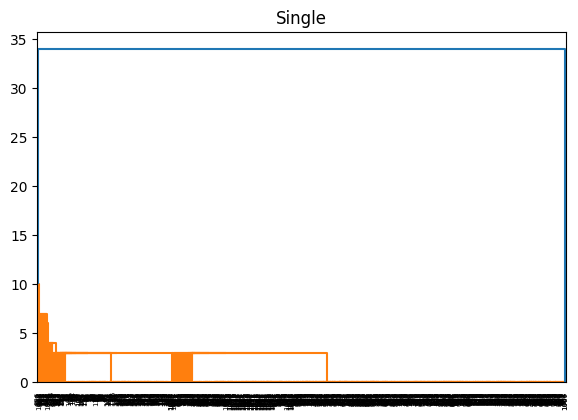

In [164]:
plot_dendrogram(linkage_matrix_vertical)

In [165]:
threshold_vertical = linkage_matrix_vertical[number_of_clusters_vertical * -1][2]
print(threshold_vertical)

7.0


In [156]:
linkage_matrix_horizontal = hierarchical_clustering(df, "min", "horizontal", threshold_vertical)
print(linkage_matrix_horizontal)

[[31, 32, 0.0, 2], [50, 51, 0.0, 2], [54, 55, 0.0, 2], [85, 86, 0.0, 2], [90, 91, 0.0, 2], [127, 128, 0.0, 2], [134, 135, 0.0, 2], [137, 138, 0.0, 2], [156, 157, 0.0, 2], [161, 162, 0.0, 2], [182, 501, 0.0, 2], [183, 184, 0.0, 2], [187, 200, 0.0, 2], [193, 194, 0.0, 2], [195, 1081, 0.0, 3], [201, 202, 0.0, 2], [203, 1083, 0.0, 3], [214, 215, 0.0, 2], [228, 229, 0.0, 2], [235, 236, 0.0, 2], [241, 510, 0.0, 2], [243, 244, 0.0, 2], [246, 247, 0.0, 2], [279, 302, 0.0, 2], [281, 282, 0.0, 2], [286, 287, 0.0, 2], [288, 289, 0.0, 2], [291, 292, 0.0, 2], [293, 1095, 0.0, 3], [299, 300, 0.0, 2], [303, 1091, 0.0, 3], [304, 305, 0.0, 2], [308, 309, 0.0, 2], [310, 1093, 0.0, 3], [313, 552, 0.0, 2], [322, 323, 0.0, 2], [324, 1103, 0.0, 3], [336, 337, 0.0, 2], [338, 1105, 0.0, 3], [358, 359, 0.0, 2], [380, 396, 0.0, 2], [394, 395, 0.0, 2], [400, 401, 0.0, 2], [426, 427, 0.0, 2], [429, 631, 0.0, 2], [442, 443, 0.0, 2], [446, 447, 0.0, 2], [451, 452, 0.0, 2], [463, 464, 0.0, 2], [499, 502, 0.0, 2], [5

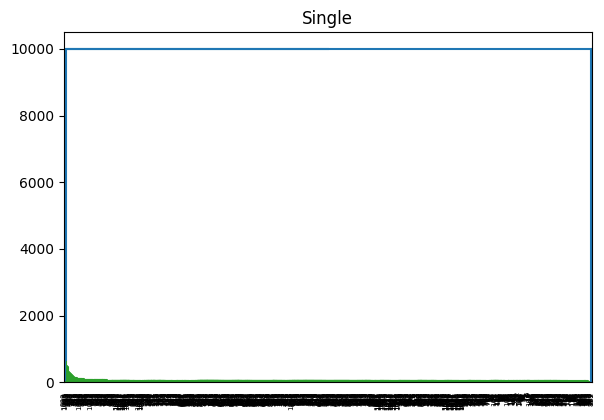

In [166]:
plot_dendrogram(linkage_matrix_horizontal)

In [167]:
threshold_horizontal = linkage_matrix_horizontal[number_of_clusters_horizontal * -1][2]
print(threshold_horizontal)

83.0


In [168]:
copy = df.copy()
zeros_array = np.zeros((len(copy), 2))
array_list = [array.tolist() for array in zeros_array]
copy['Top_box'] = array_list.copy()
copy['Bottom_box'] = array_list.copy()
copy['Left_box'] = array_list.copy()
copy['Right_box'] = array_list.copy()
print(copy)

      Unnamed: 0      Top-Left  Bottom-Right    Id               Top   
0              0    [225, 109]    [379, 150]     0    [302.0, 109.0]  \
1              1    [396, 109]    [655, 157]     1    [525.5, 109.0]   
2              2    [665, 109]    [902, 161]     2    [783.5, 109.0]   
3              3    [952, 103]   [1034, 157]     3    [993.0, 103.0]   
4              4   [1042, 106]   [1105, 150]     4   [1073.5, 106.0]   
...          ...           ...           ...   ...               ...   
1063        1063  [2183, 3268]  [2226, 3312]  1063  [2204.5, 3268.0]   
1064        1064  [2238, 3271]  [2306, 3312]  1064  [2272.0, 3271.0]   
1065        1065  [2315, 3268]  [2376, 3309]  1065  [2345.5, 3268.0]   
1066        1066   [208, 3356]   [261, 3397]  1066   [234.5, 3356.0]   
1067        1067   [290, 3367]   [309, 3394]  1067   [299.5, 3367.0]   

                Bottom              Left             Right     Top_box   
0       [302.0, 150.0]    [225.0, 129.5]    [379.0, 129.5]  [

In [169]:
ans = find_nearest_neighbours(copy, threshold_horizontal, threshold_vertical)
print(ans["Left_box"][41])

[10.0, 40.0]


In [170]:
ans = ans.drop('Unnamed: 0', axis=1)
print(ans)

          Top-Left  Bottom-Right    Id               Top            Bottom   
0       [225, 109]    [379, 150]     0    [302.0, 109.0]    [302.0, 150.0]  \
1       [396, 109]    [655, 157]     1    [525.5, 109.0]    [525.5, 157.0]   
2       [665, 109]    [902, 161]     2    [783.5, 109.0]    [783.5, 161.0]   
3       [952, 103]   [1034, 157]     3    [993.0, 103.0]    [993.0, 157.0]   
4      [1042, 106]   [1105, 150]     4   [1073.5, 106.0]   [1073.5, 150.0]   
...            ...           ...   ...               ...               ...   
1063  [2183, 3268]  [2226, 3312]  1063  [2204.5, 3268.0]  [2204.5, 3312.0]   
1064  [2238, 3271]  [2306, 3312]  1064  [2272.0, 3271.0]  [2272.0, 3312.0]   
1065  [2315, 3268]  [2376, 3309]  1065  [2345.5, 3268.0]  [2345.5, 3309.0]   
1066   [208, 3356]   [261, 3397]  1066   [234.5, 3356.0]   [234.5, 3397.0]   
1067   [290, 3367]   [309, 3394]  1067   [299.5, 3367.0]   [299.5, 3394.0]   

                  Left             Right       Top_box   Bottom

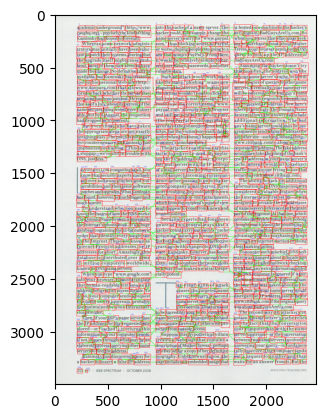

In [171]:
plt.imshow(make_connections(img, ans))

In [ ]:
original_df = pd.read_csv("./CSV/TLBR_159.csv")
print(original_df.iloc[0])
print(original_df.iloc[1])
visualize_bbox(img, original_df.iloc[1])